<a href="https://colab.research.google.com/github/grantinator/ucla-research/blob/master/FlowerRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


For each of the testing and training data, randomize how the image is fed to the neural network so it is not trained only on images of a certain orientation, or size, or any other feature like that. 

In [0]:
#Loading flower data
train_dir = '/content/drive/My Drive/flowers/train'
valid_dir = '/content/drive/My Drive/flowers/valid'
test_dir = '/content/drive/My Drive/flowers/test'

#LOADING/PREPPING DATA

#dont want to train the network on only certain orientation or size of image
#so have variations of data like rotations, mirror images, etc.
training_transforms = transforms.Compose([transforms.RandomRotation(30), #Random rotation by 30 deg
                                          transforms.RandomResizedCrop(224), #Crop at random location to 224 sq pixels
                                          transforms.RandomHorizontalFlip(), #Random horizontal flip
                                          transforms.ToTensor(), #Composes the above transforms together
                                          transforms.Normalize([0.485, 0.456, 0.406], #Normalizes tensor image?
                                                              [0.229, 0.224, 0.225])])
validation_transforms = transforms.Compose([transforms.Resize(256), 
                                            transforms.CenterCrop(224), 
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])
testing_transforms = transforms.Compose([transforms.Resize(256), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])
#Apply transforms to each data set w/ ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform = training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform = validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform = testing_transforms)

#Load data into batches so training/testing can be done in batches individually
#for computational speedd
#Batchsize is example of a hyperparamater than can be tuned
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 64, shuffle = True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 32)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size = 32)

In [0]:
#LABEL MAPPING
#Each flower type/breed has integer mapping so load in this as well
import json
flower_to_name = '/content/drive/My Drive/flower_to_name.json'
with open(flower_to_name, 'r') as f:
  flower_to_name = json.load(f)
print(len(flower_to_name))
print(flower_to_name)

102
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54'

In [0]:
#Define a model that will select features from the images of flowers to use for classification
#And will output a number between 1-1000. However, need to build on classifyer because there are 
#only numbers 1-101 for classifying the flowers
model = models.vgg16(pretrained = True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:04, 113168709.36it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Above shows that at the input layer this model takes 25088 features.

Since the model is already trained, dont want to train the parameters again/perform gradient descent on the already trained model.

In [0]:
for parameter in model.parameters():
  parameter.requires_grad = False #Dont perform gradient descent on already trained model parameters
  
from collections import OrderedDict

#Build a custom classifier because the pre-made model classifies on 1000 different 
#features not 102 which is number of flowers
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),#Take in same inputs as pre-made model. 5000 layers can be tuned as hyperparam later
                                       ('relu', nn.ReLU()),#Relu activiation function
                                       ('drop', nn.Dropout(p=0.5)),#To prevent overfitting, randomly turn off any given node in neural netowrk with prob = 50% to prevent excessive trianing on one node 
                                       ('fc2', nn.Linear(5000, 102)),#hidden layer that takes input from 5000 nodes of fc1 and outputs 1-102 to match flowers
                                       ('output', nn.LogSoftmax(dim=1))]))#Has range 0-1 which corresponds to NN probability of its guess, ie probability picture is an orange lily
                           
model.classifier = classifier


In [0]:
#Function to define validation pass REVIEW/INVESTIGATE

def validation(model, validateloader, criterion):
  
  val_loss = 0
  accuracy = 0
  
  for images, labels in iter(validateloader): #Elements in a validation block
    
    images, labels = images.to('cuda'), labels.to('cuda') #cuda converts variables to a form that works with GPU
    
    output = model.forward(images) #Pass images to the model and get an output 
    val_loss += criterion(output, labels).item()
    
    probabilities = torch.exp(output) #From above, the output is LogSoftMax of the probability of the preddiction, so exponentiate to convert to true probability
    
    equality = (labels.data == probabilities.max(dim = 1)[1]) #Equality holds bool for whether or not flower was correctly predicted?
    accuracy += equality.type(torch.FloatTensor).mean()
    
  return val_loss, accuracy

In [0]:
#Loss function to optimize w/ gradient descent
criterion = nn.NLLLoss() #This is loss function that is criteria for optimization

optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001) #lr is learning rate. hyper paramter to be tuned


In [0]:
#Train the classifier


def train_classifier():
  
  epochs = 15
  steps = 0
  print_every = 40

  model.cuda()

  for e in range(epochs): #each epoch = 1 forward and backward pass thru network

    model.train() #training mode

    running_loss = 0

    for images, labels in iter(train_loader):

      steps += 1

      images, labels = images.to('cuda'), labels.to('cuda') #Again convert to 'cuda' for GPU

      optimizer.zero_grad() #Each iteration zero out gradient 

      output = model.forward(images) #Pass images through the network to the right, output is log of probability
      loss = criterion(output, labels) #Use previously defined loss function to find error
      loss.backward() #Backpropogate error
      optimizer.step() #Update the classifier paramaters

      running_loss += loss.item()

      if steps % print_every == 0:

        model.eval() #Model in evaluation mode

        #Turn off gradient to save memory
        with torch.no_grad():
          validation_loss, accuracy = validation(model, validate_loader, criterion)

          print('Epoch {}/{}.. '.format(e+1, epochs),
               'Training Loss: {:.3f}..'.format(running_loss/print_every),
               'Validation Loss: {:.3f}..'.format(validation_loss/len(validate_loader)),
               'Validation Accuracy: {:.3f}'.format(accuracy/len(validate_loader)))
          running_loss = 0
          model.train()

train_classifier()
        

Epoch 1/15..  Training Loss: 5.472.. Validation Loss: 1.693.. Validation Accuracy: 0.572
Epoch 1/15..  Training Loss: 2.097.. Validation Loss: 0.940.. Validation Accuracy: 0.752
Epoch 2/15..  Training Loss: 0.652.. Validation Loss: 0.830.. Validation Accuracy: 0.791
Epoch 2/15..  Training Loss: 1.523.. Validation Loss: 0.677.. Validation Accuracy: 0.806
Epoch 2/15..  Training Loss: 1.466.. Validation Loss: 0.670.. Validation Accuracy: 0.823
Epoch 3/15..  Training Loss: 1.161.. Validation Loss: 0.619.. Validation Accuracy: 0.841
Epoch 3/15..  Training Loss: 1.179.. Validation Loss: 0.554.. Validation Accuracy: 0.844
Epoch 4/15..  Training Loss: 0.346.. Validation Loss: 0.539.. Validation Accuracy: 0.852
Epoch 4/15..  Training Loss: 1.191.. Validation Loss: 0.532.. Validation Accuracy: 0.864
Epoch 4/15..  Training Loss: 1.255.. Validation Loss: 0.520.. Validation Accuracy: 0.858
Epoch 5/15..  Training Loss: 0.776.. Validation Loss: 0.447.. Validation Accuracy: 0.879
Epoch 5/15..  Trainin

#Testing

In [0]:
def test_accuracy(model, test_loader):
  
  model.eval() #Put model in evaluation mode
  model.cuda() #Make sure it is in cuda for GPU
  
  with torch.no_grad():
    
    accuracy = 0
    
    for images, labels in iter(test_loader):
      
      images, labels = images.to('cuda'), labels.to('cuda')
      
      output = model.forward(images) #Pass the images through the model to receive probability of each classification
      
      probabilities = torch.exp(output) #Exponentiate probabilities because they were LogSoftMax in model
      
      equality = (labels.data == probabilities.max(dim = 1)[1]) #I think this is matching the predicted label of the output to the actual label
      #.max??
      
      accuracy += equality.type(torch.FloatTensor).mean() #Accuracy = mean of the tensor object summarizing the predictions
      
  print('Test Accuracy: {}'.format(accuracy/len(test_loader))) #The mean divided by the total number of images in the testing data

test_accuracy(model, test_loader)
      

Test Accuracy: 0.9049215316772461


#Saving Checkpoint

In [0]:
def save_checkpoint(model):
  
  model.class_to_idx = training_dataset.class_to_idx
  
  checkpoint = {'arch':'vgg16',
               'class_to_idx':model.class_to_idx,
               'model_state_dict':model.state_dict()}
  torch.save(checkpoint, '')
  
save_checkpoint(model)

#Load Checkpoint

In [0]:
from collections import OrderedDict

def load_checkpoint(filepath):
  
  checkpoint = torch.load(filepath)
  
  if checkpoint['arch'] == 'vgg16':
    
    model = models.vgg16(pretrained = True)
    
    for param in model.parameters():
      param.requires_gard = False
      
    else:
      print("Architecture not recognized")
      
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(5000, 102)),
                                            ('output', nn.LogSoftmax(dim=1))]))
    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model
    
load_checkpoint()
      

FileNotFoundError: ignored

#Prediction
Function called predict that takes an image that returns the K most likely class predictions for the image and their respective probabilities.


In [0]:
#Function to preprocess image for the network
from PIL import Image

def process_image(image_path):
  #scales, crops, and normalizes PIL image and returns numpy array for the network
  
  pil_image = Image.open(image_path)
  
  #Resize
  if pil_image.size[0] > pil_image.size[1]:
    pil_image.thumbnail((5000, 256))
  else:
    pil_image.thumbnail((256, 5000)) 
  
  #Crop
  left_margin = (pil_image.width-224)/2
  bottom_margin = (pil_image.height-224)/2
  right_margin = left_margin + 224
  top_margin = bottom_margin + 224
  
  pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
  
  #Normalize image 
  np_image = np.array(pil_image)/255 #Can be tensor from PyTorch?
  mean = np.array([0.485, 0.456, 0.406]) #Mean from initial formatting in network
  std = np.array([0.229, 0.224, 0.225]) #Sd from initial in network
  np_image = (np_image - mean) / std
  
  #Need to make the color channel the first dimension for PyTorch - currently
  #third dimension in PIL array
  
  np_image = np_image.transpose((2, 0, 1))
    
  return np_image

Function to display the image

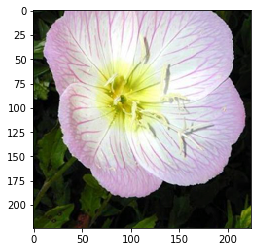

In [0]:
def imshow(image, ax = None, title = None):
  if ax is None:
    fig, ax = plt.subplots()
    
  #PyTorch has color channel as first dimension but MatPlotLib expects it as 3rd
  image = image.transpose((1, 2, 0))
  
  # Undo preprocessing
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  
  if title is not None:
       ax.set_title(title)
      
  # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
  image = np.clip(image, 0, 1)

  ax.imshow(image)

  return ax

image = process_image('/content/drive/My Drive/flowers/test/1/image_06743.jpg')
imshow(image)

In [0]:
def predict(image, model, topk=5):
  
  image = process_image(image) #Preprocess image for network
  
  #Convert image to PyTorch tensor
  image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
  
  image = image.unsqueeze(0)
  
  output = model.forward(image) #Forward pass image thru model
  
  probabilities = torch.exp(output)
  
  top_probabilities, top_indices = probabilities.topk(topk)
  
  #Convert to lists
  top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0]
  top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
  
  #Convert indices to flower breeds using index to class
  #First invert dictionary to get mapping from index to class
  idx_to_class = {value:key for key, value in model.class_to_idx.items()}
  
  #Top guesses
  top_guesses = [idx_to_class[index] for index in top_indices]
  top_names = [flower_to_name[i] for i in top_guesses]
  
  return top_probabilities, top_guesses, top_names

probs, classes, top_names = predict('/content/drive/My Drive/flowers/test/1/image_06743.jpg', model)   
print(probs)
print(classes)
print(top_names)


NameError: ignored